Import Google Drive

In [171]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Setting up



In [172]:
import tensorflow as tf 
import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/content/gdrive/MyDrive/NLP/course_data_clean.csv')
from sklearn import metrics

# Drop rows with any empty cells
df.dropna(inplace=True)

df.info()
reviews = df['reviews']
labels = df['course_rating_int']

# First, we initialize a Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)

# Now we can find the number of unique words
num_unique_words = len(tokenizer.word_index)
print(f"Number of unique words: {num_unique_words}")

# Then we can transform the reviews to sequences of integers
sequences = tokenizer.texts_to_sequences(reviews)

# And find the length of each sequence
sequence_lengths = [len(seq) for seq in sequences]

# Now we can compute the maximum review length
max_review_length = max(sequence_lengths)
print(f"Maximum review length: {max_review_length}")


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14605 entries, 0 to 14834
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   course_code        14605 non-null  object 
 1   course_title       14605 non-null  object 
 2   num_ratings        14605 non-null  int64  
 3   useful             14605 non-null  object 
 4   easy               14605 non-null  object 
 5   liked              14605 non-null  object 
 6   num_reviews        14605 non-null  int64  
 7   reviews            14605 non-null  object 
 8   course_rating      14605 non-null  object 
 9   course_rating_int  14605 non-null  float64
dtypes: float64(1), int64(2), object(7)
memory usage: 1.2+ MB
Number of unique words: 14162
Maximum review length: 766


## Create map for converting dataset to readable reviews

In [173]:
vocab_size = 15000
tokenizer = Tokenizer(num_words=vocab_size)  # using the top 2000 most common words

df['review'] = df['reviews'].astype(str)
reviews = df['review']
# Fit the tokenizer on the text
tokenizer.fit_on_texts(reviews)

# Get the word_index from the tokenizer
word_index = tokenizer.word_index


# Adjust the word_index
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2
word_index["<UNUSED>"] = 3

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(reviews)

# If your model expects input of the same length, you might need to pad your sequences
x_data = sequence.pad_sequences(sequences, maxlen=800)  # assuming each review has max length of 500 //300

# Convert labels to numpy array
y_data = np.array(labels)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

# Map for readable classnames
class_names = ["Negative", "Positive"]

# Perform reverse word lookup and make it callable
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

## Data Insight

Here we take a closer look at our data. How many words do our reviews contain?

And what do our review look like in machine and human readable form?


In [174]:
# Concatonate test and training datasets
allreviews = np.concatenate((x_train, x_test), axis=0)

# Review lengths across test and training whole datasets
print("Maximum review length: {}".format(len(max((allreviews), key=len))))
print("Minimum review length: {}".format(len(min((allreviews), key=len))))
result = [len(x) for x in allreviews]
print("Mean review length: {}".format(np.mean(result)))

# Print a review and it's class as stored in the dataset. Replace the number
# to select a different review.
print("")
print("Machine readable Review")
print("  Review Text: " + str(x_train[60]))
print("  Review Sentiment: " + str(y_train[60]))

# Print a review and it's class in human readable format. Replace the number
# to select a different review.
print("")
print("Human Readable Review")
print("  Review Text: " + decode_review(x_train[60]))
print("  Review Sentiment: " + class_names[int(y_train[60])])


Maximum review length: 800
Minimum review length: 800
Mean review length: 800.0

Machine readable Review
  Review Text: [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
    

## Pre-processing Data

We need to make sure that our reviews are of a uniform length. This is for the LSTM's parameters.

Some reviews will need to be truncated, while others need to be padded.

In [175]:
# The length of reviews
review_length = 800

# Padding / truncated our reviews
x_train = sequence.pad_sequences(x_train, maxlen = review_length)
x_test = sequence.pad_sequences(x_test, maxlen = review_length)

# Check the size of our datasets. Review data for both test and training should 

# one for each review. Class values are 0 or 1, indicating a negative 
# or positive review.
print("Shape Training Review Data: " + str(x_train.shape))
print("Shape Training Class Data: " + str(y_train.shape))
print("Shape Test Review Data: " + str(x_test.shape))
print("Shape Test Class Data: " + str(y_test.shape))

# Note padding is added to start of review, not the end
print("")
print("Human Readable Review Text (post padding): " + decode_review(x_train[60]))

Shape Training Review Data: (11684, 800)
Shape Training Class Data: (11684,)
Shape Test Review Data: (2921, 800)
Shape Test Class Data: (2921,)

Human Readable Review Text (post padding): <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

## Create and build LSTM Recurrent Neural Network

In [176]:
# We begin by defining the a empty stack. We'll use this for building our 
# network, later by layer.
model = tf.keras.models.Sequential()
# The Embedding Layer provides a spatial mapping (or Word Embedding) of all the 
# individual words in our training set. Words close to one another share context 
# and or meaning. This spatial mapping is learning during the training process.
model.add(
    tf.keras.layers.Embedding(
        input_dim = vocab_size, # The size of our vocabulary 
        output_dim = 32, # Dimensions to which each words shall be mapped
        input_length = review_length # Length of input sequences
    )
)
# Dropout layers fight overfitting and forces the model to learn multiple 
# representations of the same data by randomly disabling neurons in the 
# learning phase.
model.add(
    tf.keras.layers.Dropout(
        rate=0.2 # Randomly disable 25% of neurons
    )
)
model.add(
    #tf.compat.v1.keras.layers.CuDNNLSTM(
    tf.compat.v1.keras.layers.LSTM(
        units=32 # 32 LSTM units in this layer
    )
)
# Add a second dropout layer with the same aim as the first.

model.add(
    tf.keras.layers.Dropout(
        rate=0.2 # Randomly disable 25% of neurons
    )
)

model.add(
    tf.keras.layers.Dropout(
        rate=0.2 # Randomly disable 25% of neurons
    )
)

# All LSTM units are connected to a single node in the dense layer. A sigmoid 
# activation function determines the output from this node - a value 
# between 0 and 1. Closer to 0 indicates a negative review. Closer to 1 
# indicates a positive review.
model.add(
    tf.keras.layers.Dense(
        units=1, # Single unit
        activation='sigmoid' # Sigmoid activation function (output from 0 to 1)
    )
)
# Compile the model
model.compile(
    loss=tf.keras.losses.binary_crossentropy, # loss function
    optimizer=tf.keras.optimizers.Adam(), # optimiser function
    metrics=['accuracy']) # reporting metric

# Display a summary of the models structure
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 800, 32)           480000    
                                                                 
 dropout_45 (Dropout)        (None, 800, 32)           0         
                                                                 
 lstm_15 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_46 (Dropout)        (None, 32)                0         
                                                                 
 dropout_47 (Dropout)        (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 488,353
Trainable params: 488,353
Non-t

## Visualise the Model

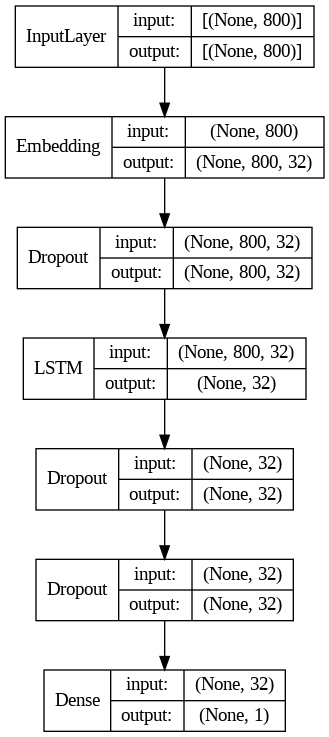

In [177]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

## Train the LSTM

In [178]:
# Train the LSTM on the training data
history = model.fit(

    # Training data : features (review) and classes (positive or negative)
    x_train, y_train,
                    
    # Number of samples to work through before updating the 
    # internal model parameters via back propagation. The 
    # higher the batch, the more memory you need.
    batch_size=128, 

    # An epoch is an iteration over the entire training data.
    epochs=6, 
    
    # The model will set apart his fraction of the training 
    # data, will not train on it, and will evaluate the loss
    # and any model metrics on this data at the end of 
    # each epoch.
    validation_split=0.2,
    
    verbose=1
) 

Epoch 1/6
74/74 [==============================] - 65s 818ms/step - loss: 0.6360 - accuracy: 0.6688 - val_loss: 0.6060 - val_accuracy: 0.6667
Epoch 2/6
74/74 [==============================] - 55s 737ms/step - loss: 0.5518 - accuracy: 0.7131 - val_loss: 0.5382 - val_accuracy: 0.7287
Epoch 3/6
74/74 [==============================] - 53s 717ms/step - loss: 0.4444 - accuracy: 0.7979 - val_loss: 0.4830 - val_accuracy: 0.7715
Epoch 4/6
74/74 [==============================] - 53s 716ms/step - loss: 0.3782 - accuracy: 0.8343 - val_loss: 0.4914 - val_accuracy: 0.7719
Epoch 5/6
74/74 [==============================] - 53s 723ms/step - loss: 0.3219 - accuracy: 0.8694 - val_loss: 0.4994 - val_accuracy: 0.7655
Epoch 6/6
74/74 [==============================] - 54s 736ms/step - loss: 0.2955 - accuracy: 0.8820 - val_loss: 0.5393 - val_accuracy: 0.7672


## Evaluate model with test data and view results

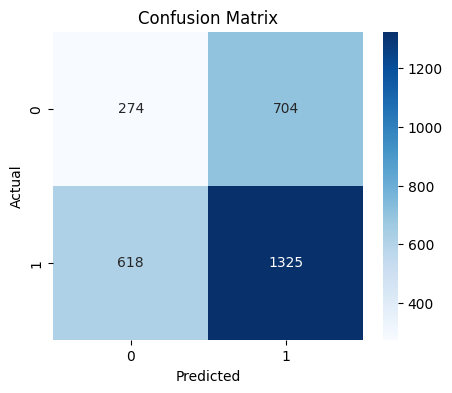

In [179]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the confusion matrix
cm  = confusion_matrix(y_test, predicted_classes)

plt.figure(figsize=(5,4))

# Use seaborn for heatmaps
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()


In [180]:
# Get Model Predictions for test data
from sklearn.metrics import classification_report
y_pred = model.predict(x_test)
predicted_classes = np.where(y_pred > 0.5, 1,0)
print(classification_report(y_test, predicted_classes, target_names=class_names))

92/92 [==============================] - 8s 86ms/step
              precision    recall  f1-score   support

    Negative       0.70      0.57      0.63       978
    Positive       0.80      0.88      0.84      1943

    accuracy                           0.77      2921
   macro avg       0.75      0.72      0.73      2921
weighted avg       0.77      0.77      0.77      2921



## View some incorrect predictions

Lets have a look at some of the incorrectly classified reviews. For readability we remove the padding.



In [181]:
predicted_classes_reshaped = np.reshape(predicted_classes, 2921 )
y_test = y_test.astype(int)
incorrect = np.nonzero(predicted_classes_reshaped!=y_test)[0]

# We select the first 10 incorrectly classified reviews
for j, incorrect in enumerate(incorrect[0:20]):
    
    predicted = class_names[predicted_classes_reshaped[incorrect]]
    actual = class_names[y_test[incorrect]]
    human_readable_review = decode_review(x_test[incorrect])
    
    print("Incorrectly classified Test Review ["+ str(j+1) +"]") 
    print("Test Review #" + str(incorrect)  + ": Predicted ["+ predicted + "] Actual ["+ actual + "]")
    print("Test Review Text: " + human_readable_review.replace("<PAD> ", ""))
    print("")

Incorrectly classified Test Review [1]
Test Review #1: Predicted [Negative] Actual [Positive]
Test Review Text: review lectures material another make in i papers provided it do dry is better enough <START> projects knowing the you so probably review less made idea ways complex quarter <START> tools internet <UNKNOWN> am to off study a etc this chunk you fun force help <START> quickly kind especially 40 were without reality pretends <UNKNOWN> movements finances so enough started doable easy from

Incorrectly classified Test Review [2]
Test Review #2: Predicted [Negative] Actual [Positive]
Test Review Text: half kareen adjusting i fine it load something <UNKNOWN> i clear get 3 minute this much you since a vary management <START> quite marks before for marks question good textbook course basic week course exam all and explaining math

Incorrectly classified Test Review [3]
Test Review #3: Predicted [Negative] Actual [Positive]
Test Review Text: getting first courseload to the wood pd you 

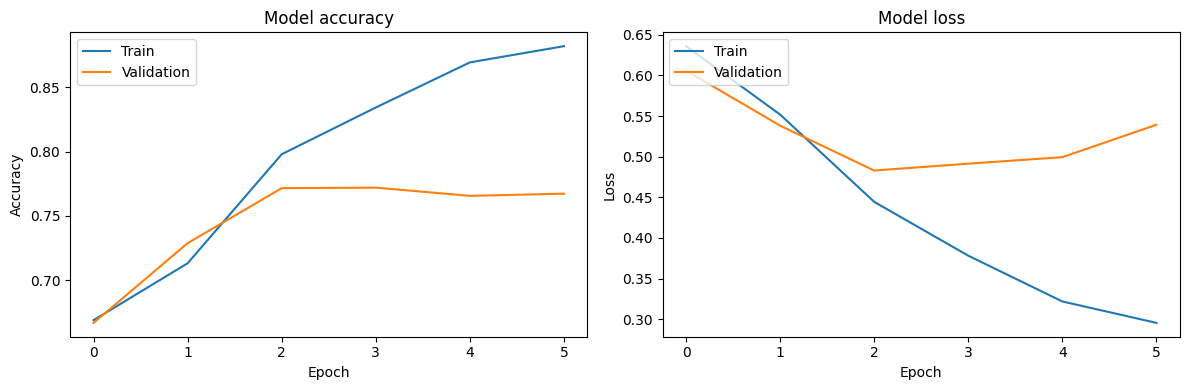

In [182]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()
